# Chapter 8: Generating High-Resolution Images with Diffusion Models


This chapter covers

* The DDIM noise scheduler
* Adding the attention mechanism in denoising U-Net models
* Using sine and cosine functions to embed time steps
* Generating high-resolution images with diffusion models
* Interpolating initial noise tensors to generate composite images

You have learned the basics of the diffusion models in the previous two chapters. Specifically, you learned the basic idea behind the forward and reverse diffusion processes and how to train a denoising U-Net model to remove noise from images. Once the model is trained, you can start with pure noise and ask the model to iteratively remove noise from the image until the output is indistinguishable from images in the training dataset. Further, you can also condition the image generation on some type of information (e.g., image labels) and the generated image will match the conditioning information. The ability of the diffusion models to generate images conditionally is important because all state of the art text to image models essentially generate images conditional on text prompts. 

To make the model simple and easy-to-train, we used grayscale images of clothing items in the previous two chapters. To generate high resolution images, say, color images of size 512x512, we need more sophisticated models due to the sheer size of these images. In this chapter, you'll learn state-of-the-art diffusion models to generate flower images of size (3, 512, 512): meaning three color channels (red, green, and blue), with height and width of 512 pixels. 

Specifically, you'll learn a new type of noise scheduler: denoising diffusion implicit models (DDIM). The key difference is that while the denoising diffusion probabilistic models (DDPM) we studied in the previous two chapters use a stochastic sampling process and a Markovian process, DDIM uses a deterministic approach and a non-Markovian process. As a result, DDIM generally requires fewer steps for sampling and are more efficient than DDPM. 

We also make two improvements on the denoising U-Net model in this chapter. First, we'll add more downsampling and upsampling layers in the U-Net to allow the model to learn the fine-grained details from the input image. However, the large size of the model also complicates the identification of relevant features, similar to searching for a needle in a haystack. As a result, we include the scaled dot product attention (SDPA) mechanism in the U-Net. The attention mechanism empowers the model to emphasize significant features while disregarding irrelevant ones, thereby enhancing the effectiveness of the learning process. Second, we'll use a more sophisticated way of embedding the time steps in the U-Net. We'll use sinusoidal functions (i.e., sine and cosine functions) to embed the time steps. These embeddings are fixed for each time step and the model doesn't need to learn the embedding values. This reduces the number of parameters the model needs to train.

In this chapter,  you will build and train a diffusion model from scratch to generate high-resolution color flower images. This will provide you with a deep understanding of the state of the art diffusion models. 

Once the diffusion model is trained, the generated images are determined by the initial noise tensor at time step T=1000. Different intial noise tensors lead to different images: while one tensor leads to a white lily, the other tensor may lead to a yellow aster, for example. To drive home the message of how the initial tensors determine the final generated images, we'll interpolate two initial noise tensors to generate a series of composite images that gradually transition from one image to the other. Specifically, you'll create a new initial noise tensor by assigning different weights to the two existing initial noise tensors (which lead to a white lily and a yellow aster, respectively, for example). You'll feed the new initial noise tensor to the trained U-Net and create a composite image as a result. By choosing different weights, we can create a series of intermediate images that transition from one image to another (from a white lily to a yellow aster, for example). 

# 1. Add the Attention Mechanism to the Denoising U-Net
In this section, we'll discuss the new features in the denoising U-Net model compared to the U-Net models we used in the previous chapter. First, we'll use sine and cosine functions to embed the time steps in the U-Net model, as we did in Chapter 2 when building the Transformer to translate German to English. Since these embeddings are fixed for each time step, and the U-Net model has fewer learnable parameters. This, in turn, speeds up the training process. Second, we'll include the attention mechanism in the U-Net, allowing the model to identify the importance of different features. The U-Net model can emphasize important features and disregard irrelevant ones. This, in turn, makes the learning more effective. 

## 1.1 Embed time steps with sine and cosine functions
Sinusoidal time step embeddings are a technique used in diffusion models to encode the time step information in a way that helps the model learn the dynamics of the diffusion process. It uses sine and cosine functions with different frequencies, hence the name sinusoidal. It can be incorporated in both denoising diffusion probabilistic models (DDPM, which you have seen in the previous two chapters) and denoising diffusion implicit models (DDIM, which we'll discuss later in this chapter). This approach is inspired by the positional encodings used in Transformer models, as you've seen in Chapter 2. Below, we provide a detailed explanation of how sinusoidal time step embeddings work. 

Diffusion models involve a forward process (diffusion) and a reverse process (denoising). In the forward process, noise is gradually added to the data over many time steps, transforming it into a Gaussian noise distribution. In the reverse process, the model learns to progressively denoise this noisy data, recovering the original data distribution. For the reverse process, it is crucial for the model to know the specific time step it is currently operating on. This is because the amount of noise to be removed and the nature of the denoising task depend on how far along the data is in the diffusion process.

Sinusoidal embeddings provide a way to encode the time step information into a fixed-dimensional vector that can be used by the model. This is achieved using sine and cosine functions with different frequencies. The key idea is to represent each time step t as a combination of sine and cosine functions to capture the periodic nature of time steps in a way that is both unique and continuous. Given a time step t, the sinusoidal embedding is defined as:

$$PE(t,2i)=sin(\frac{t}{10000^{2i/d}})$$
$$PE(t,2i+1)=cos(\frac{t}{10000^{2i/d}})$$

where i is the dimension index, d is the total dimensionality of the embedding, and t is the time step. $PE(t,2i)$ is the value at the even indexes in the embedding and $PE(t,2i+1)$ is the value at the odd indexes. 

The term $1/10000^{2i/d}$ determines the frequency of the sinusoidal functions. Lower dimensions (smaller i) have higher frequencies, while higher dimensions (larger i) have lower frequencies. This allows the embedding to capture both high-frequency (fine-grained) and low-frequency (coarse-grained) information about the time steps.

There are a few advantages of using sinusoidal embeddings. The embeddings change smoothly with respect to the time step, which helps the model learn the continuous nature of the diffusion process. Each time step has a unique representation, making it easy for the model to distinguish between different stages of the diffusion process. Unlike learned embeddings, sinusoidal embeddings do not require additional parameters to be trained, reducing the model complexity.

In practice, the sinusoidal time step embeddings are concatenated or added to other input features of the model, such as the noisy data at a given time step. This enriched input helps the model to condition its predictions on both the current state of the data and the corresponding time step, improving the overall performance of the denoising process.

For example, we can find out the time embeddings for time steps 7, 42, and 123, as follows, assuming an embedding dimension of 128 (meaning each time step is represented by a 128-value vector):

In [1]:
import torch, math

# embedding dimension is 128
dim=128
# look at three time steps: 7, 42, and 123
timesteps = torch.tensor([7, 42, 123],dtype=torch.long)
# half dimension
half_dim = dim // 2
exponent = -math.log(10000) * torch.arange(
        start=0, end=half_dim, dtype=torch.float32)
exponent = exponent / (half_dim - 1.0)
emb = torch.exp(exponent)
emb = timesteps[:, None].float() * emb[None, :]
# even dimension indexes
emb_even=emb.sin()
# even dimension indexes
emb_odd=emb.cos()
time_emb=torch.cat([emb_even, emb_odd], dim=-1)
print(time_emb)

tensor([[ 6.5699e-01, -2.3310e-01, -8.7130e-01, -9.8051e-01, -6.8819e-01,
         -2.2649e-01,  2.2788e-01,  5.8585e-01,  8.2380e-01,  9.5322e-01,
          9.9867e-01,  9.8575e-01,  9.3602e-01,  8.6563e-01,  7.8586e-01,
          7.0407e-01,  6.2480e-01,  5.5060e-01,  4.8274e-01,  4.2165e-01,
          3.6726e-01,  3.1922e-01,  2.7705e-01,  2.4017e-01,  2.0802e-01,
          1.8006e-01,  1.5579e-01,  1.3474e-01,  1.1650e-01,  1.0071e-01,
          8.7053e-02,  7.5237e-02,  6.5020e-02,  5.6186e-02,  4.8551e-02,
          4.1952e-02,  3.6248e-02,  3.1320e-02,  2.7061e-02,  2.3381e-02,
          2.0202e-02,  1.7454e-02,  1.5080e-02,  1.3029e-02,  1.1257e-02,
          9.7263e-03,  8.4035e-03,  7.2605e-03,  6.2730e-03,  5.4198e-03,
          4.6827e-03,  4.0458e-03,  3.4955e-03,  3.0201e-03,  2.6093e-03,
          2.2544e-03,  1.9478e-03,  1.6829e-03,  1.4540e-03,  1.2562e-03,
          1.0854e-03,  9.3774e-04,  8.1020e-04,  7.0000e-04,  7.5390e-01,
          9.7245e-01,  4.9074e-01, -1.

The output shows the time embeddings for time steps 7, 42, and 123. Each time embedding has a dimension of 128. For example, time step 7 is represented by a 128-value tensor [6.5699e-01, -2.3310e-01, ..., 1.0000e+00]. 

Furthermore, these time embeddings are fixed, meaning they don't change during training. This helps reduce the total number of trainable model parameters and speed up the training process. 

## 1.2 Incorporate the Attention Mechanism in the U-Net
U-Net architectures are popular in diffusion models due to their ability to capture and process features at multiple resolutions. The symmetric encoder-decoder structure with skip connections helps in preserving spatial details while performing extensive feature extraction and reconstruction.

Attention mechanisms enable the network to focus on important parts of the input data, dynamically adjusting the influence of different spatial locations based on their relevance. This improves the network's ability to capture dependencies and relationships between distant spatial regions, which is crucial for complex tasks like denoising.

Scaled dot-product attention (SDPA) is a core component of the attention mechanism used in models like Transformers. As we discussed in detail in Chapters 2 to 4, it involves three main components: Queries (Q), Keys (K), and Values (V). To calculate attention, we first calculate the attention scores using the dot product of Queries and Keys. These scores indicate the relevance of each element in the sequence to every other element. The attention scores are scaled by the square root of the dimensionality of the Keys. This scaling helps mitigate the issue of large dot-product values which can lead to small gradients during backpropagation. The scaled scores are passed through a softmax function to obtain the attention weights, which sum to one. These weights represent the relative importance of each element. The final output is obtained by taking the weighted sum of the Values, where the weights are the attention weights computed in the previous step.

Mathematically, the SDPA is expressed as:
$$Attention(Q,K,V)=softmax(\frac{Q* K_{transpose}}{\sqrt{d_k}})* V$$

where $d_k$ is the dimensionality of the Keys.

The benefits of including SDPA in denoising U-Net models are as follows. SDPA allows the model to weigh the importance of different spatial regions dynamically. This is crucial for denoising tasks, where understanding the broader context of the noisy data helps in predicting the clean data more accurately. By computing the relevance between distant spatial locations, SDPA enables the model to capture long-range dependencies effectively. This is particularly important in diffusion models, where noise added in the forward process can affect the entire spatial structure. The scaled dot-product computation is efficient and enables the model to process large amounts of information quickly. This efficiency is essential for handling high-resolution data in denoising tasks. SDPA can be seamlessly integrated into the U-Net architecture, enhancing the encoder and decoder paths with contextual information. This integration allows the model to benefit from the strengths of both U-Net’s multi-resolution feature extraction and SDPA’s dynamic attention.

# 2 Denoising Diffusion Implicit Models (DDIM)
DDIM (Denoising Diffusion Implicit Models) and DDPM (Denoising Diffusion Probabilistic Models) are two types of diffusion models used for generative tasks, but there are differences in their formulations and applications. While you have coded DDPM from scratch in the previous chapter, you'll use DDIM in this chapter. 

This section first explains the difference between the two models and why we choose DDIM over DDPM when generating high resolution images. We'll then implement DDIM with Python and PyTorch. 

The Python programs in this chapter are adapted from Hugging Face’s GitHub repository https://github.com/huggingface/diffusers and Filip Basara's GitHub repository https://github.com/filipbasara0/simple-diffusion. 

## 2.1 What Is DDIM?
DDIM is first proposed by Song, Meng, and Ermon in 2020 in a paper titled Denoising Diffusion Implicit Models (https://arxiv.org/abs/2010.02502). The authors show that while DDPMs have achieved high quality image generation without adversarial training, they require simulating a Markov chain for many steps to produce a sample. For color images with high resolutions, this can be extremely computationally-intensive and time-consuming. They show that DDIMs are a more efficient class of iterative implicit probabilistic models. In DDPMs, a Markkovian diffusion process is used, and the generative process in DDPMs is defined as the reverse of a Markovian diffusion process. The defining characteristic of a Markovian process is the memoryless property. This means the future state of the process depends only on the present state and not on the sequence of events that preceded it. In contrast, a non-Markovian process retains memory of past states. The future state depends not only on the present state but also on one or more previous states. 

Song, Meng, and Ermon (2020) construct a class of non-Markovian diffusion processes that lead to the same training objective, but whose reverse process can be much faster to sample from compared to DDPMs. They demonstrate that DDIMs can produce high quality samples 10 to 50 times faster compared to DDPMs. Further, DDPMs use a stochastic sampling process, while DDIMs use a deterministic approach.  DDIMs generally require fewer steps for sampling, making it more efficient. 

Further, DDIM’s non-Markovian process allows for more flexibility in the denoising step. In particular, Equation (12) in Song, Meng, and Ermon (2020) shows the reverse diffusion process as 
$$ x_{t-1} = \sqrt{\bar{α}_{t-1}} * (\text{ predicted } x_0) + (\text{ direction pointing to } {x}_t) + \sigma_{t} \epsilon_{t} $$

where $\epsilon_{t}$ follows a standard normal distribution and $\sigma_{t}$ governs how much random noise is in the reverse diffusion process. A special case is when $\sigma_{t}=0$, and the reverse diffusion process becomes deterministic. 



## 2.2 Visualize the forward diffusion process in DDIM
To save space, we’ll place most helper functions and classes in a local module ddim_util.py. Download the file from the book’s GitHub repository https://github.com/markhliu/txt2img and place it in the /utils/ folder on your computer. 

In the file ddim_util.py you just downloaded, we define a class DDIMScheduler() to model the DDIM. Take a look at the definition of the class and familiarize yourself with various attributes and methods in the class. 

In particular, we'll add noise to several images to visualize how the forward diffusion process works in DDIM. Go to the book's GitHub repository https://github.com/markhliu/txt2img and download the following four images from the /files/ folder: bunny.png, fish.png, deer.png, and apple.png. Place these four images in the /files/ folder on your computer. Then run the following code block:

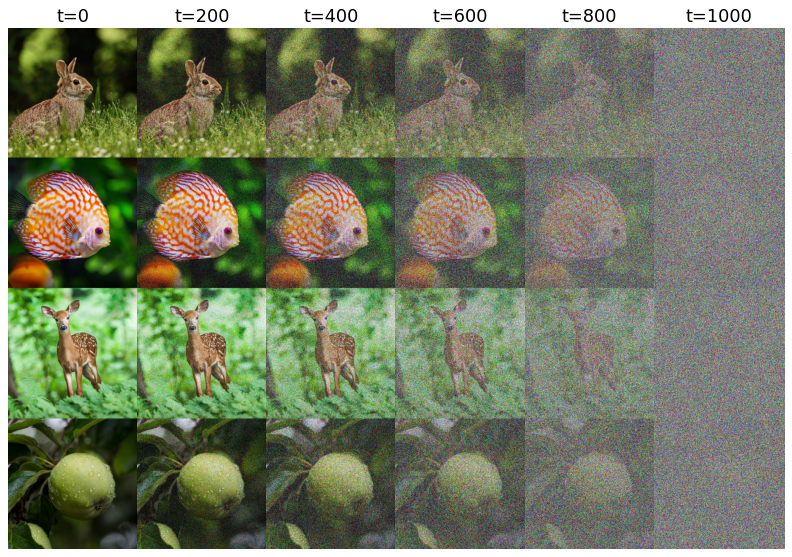

In [2]:
import matplotlib.pyplot as plt
import PIL
import numpy as np

# import the DDIMScheduler() class
from utils.ddim_util import DDIMScheduler
noise_scheduler=DDIMScheduler(num_train_timesteps=1000)
    
imgs=[]
# iterate through the four images
for name in ["bunny","fish","deer","apple"]:
    img=np.array(PIL.Image.open(f"files/{name}.png"))
    img=torch.tensor(2*(img/255)-1)
    imgs.append(img)
imgs=torch.cat(imgs)

allimgs=[imgs]
# obtain the noisy images at time steps 200, ..., 1000
for step in [200,400,600,800,1000]:
    timesteps=torch.tensor([step-1]).long()
    noisy_image=noise_scheduler.add_noise(imgs,
         torch.randn(imgs.shape), timesteps)
    allimgs.append(noisy_image)
       
# plot the images
plt.figure(figsize=(10,8),dpi=80)
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.imshow(torch.clip(allimgs[i]/2+0.5,0,1))
    plt.axis('off')
    plt.title(f"t={200*i}",fontsize=16)
plt.tight_layout(w_pad=-0.1)
plt.show()

We use T=1000 time steps in the forward diffusion process, in whcih noise is gradually added to the images. The left column is time step 0, when the four iamges are the original clean images, without any noise added to them. The second columns shows time step 200, when some noise is added to the images. As we move to the right, more and more noise is added to the images, until at time step T=1000, when the four images become pure random noise. 

# 3 High-Resolution Flower Images as Training Data
To train the denoising U-Net model, we’ll use the Oxford 102 Flower dataset, which contains roughly 8000 flower images. You'll use the datasets library to download the data from Hugging Face to your computer. You'll then visualize the images in the training dataset and place the data in batches so that we can use them to train the denosing U-Net model later in this chapter.

## 3.1 Visualize Images in the Training Dataset
Make sure you have the datasets library installed in the virtual environment by pip installing it. The load_dataset() method from the datasets library allows you to directly download the Oxford 102 Flower dataset from Hugging Face directly, like so: 


In [3]:
from datasets import load_dataset
from torchvision.transforms import (CenterCrop,
    Compose,InterpolationMode,RandomHorizontalFlip,
    Resize,ToTensor)

resolution=64

augmentations = Compose([
    Resize(resolution, 
    interpolation=InterpolationMode.BILINEAR),
    CenterCrop(resolution),
    RandomHorizontalFlip(),
    ToTensor(),])

def transforms(examples):
    images = [augmentations(image.convert("RGB"))
        for image in examples["image"]]
    return {"input": images}

dataset = load_dataset("huggan/flowers-102-categories",
    split="train",)    
dataset.set_transform(transforms)

To prepare for training, we place the dataset in batches of 4 so that we can use them to train the denoising U-Net model later. We choose a batch size of 4 to keep the memory size small enough to fit on a GPU during training. Adjust the batch size to 2 or even 1 (or switch to CPU training) if your GPU memory is small.

In [4]:
import torch

torch.manual_seed(42)
batch_size=4
train_dataloader=torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True)

Next, we use the matplotlib library to visualize some examples of the flower images in the dataset:


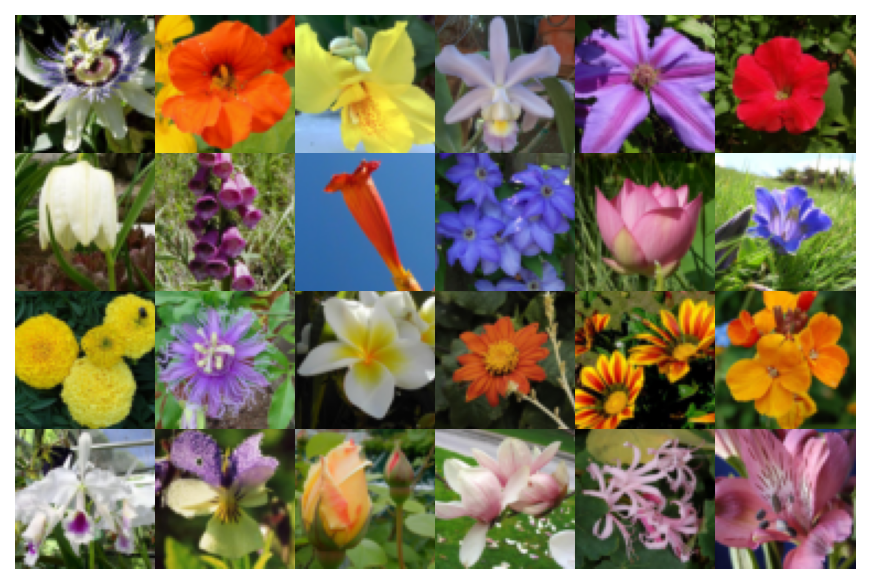

In [5]:
import matplotlib.pyplot as plt

# plot the images
plt.figure(figsize=(5.9,batch_size),dpi=150)
for col in range(6):
    imgs=next(iter(train_dataloader))["input"]
    for row in range(batch_size):
        plt.subplot(batch_size,6,col+1+row*6)
        img=imgs[row].permute(1,2,0)#/2+0.5
        plt.imshow(torch.clip(img,0,1))
        plt.axis('off')
plt.tight_layout(h_pad=-0.025,w_pad=-0.025)
plt.show()

These are high-resolution color images of various types of flowers. We have standardized the size of each image to (3, 64, 64). 

## 3.2.	Forward Diffusion on Flower Images
Now, we apply the noise scheduler on the clean flower images to add noise to them so that we can visualize the forward diffusion process in our training data. 

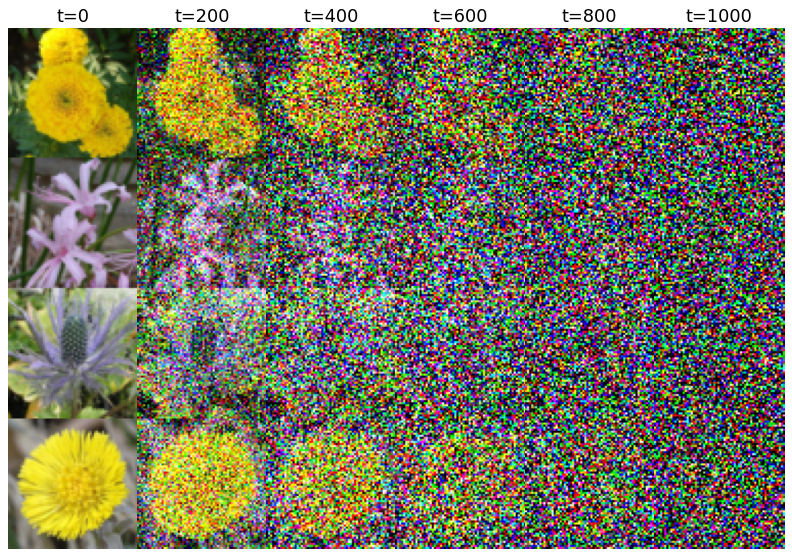

In [6]:
from utils.ddim_util import DDIMScheduler
noise_scheduler=DDIMScheduler(num_train_timesteps=1000)

imgs=next(iter(train_dataloader))["input"]
imgs=imgs.permute(0,2,3,1).reshape(-1,64,3)

allimgs=[imgs]
# obtain the noisy images at time steps 200, ..., 1000
for step in [200,400,600,800,1000]:
    timesteps=torch.tensor([step-1]).long()
    noisy_image=noise_scheduler.add_noise(imgs,
         torch.randn(imgs.shape), timesteps)
    allimgs.append(noisy_image)
       
# plot the images
plt.figure(figsize=(10,8),dpi=80)
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.imshow(torch.clip(allimgs[i],0,1))
    plt.axis('off')
    plt.title(f"t={200*i}",fontsize=16)
plt.tight_layout(w_pad=-0.1)
plt.show()

The first column contains the four clean images without noise. As we move to the right, we gradually add more and more noise to the images. The very last column contains pure random noise. 

# 4. Build and Train a Denoising U-Net Model
In this section, we create a denoising U-Net model by incorporating the attention mechanism and sinusoidal time embedding we discussed earlier in the chapter. We'll use DDIM to add noise to the training images we prepared earlier.  


## 4.1 Time Embedding and Attention in the U-Net
In the local module file ddim_util.py, we define the U-Net model. In particular, the file contains a sinusoidal_embedding() function as follows:

```python
def sinusoidal_embedding(timesteps, dim):
    half_dim = dim // 2
    exponent = -math.log(10000) * torch.arange(
        start=0, end=half_dim, dtype=torch.float32)
    exponent = exponent / (half_dim - 1.0)
    emb = torch.exp(exponent).to(device=timesteps.device)
    emb = timesteps[:, None].float() * emb[None, :]
    return torch.cat([emb.sin(), emb.cos()], dim=-1)
```

To implement the attention mechanism, we have defined an Attention() class in the local module ddim_util.py, as shown below:

```python
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)
    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, m=1)    #A
        q, k, v = map(
        lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h=self.heads),
      qkv)    #B
        q = q * self.scale    
        sim = einsum('b h d i, b h d j -> b h i j', q, k)
        attn = sim.sofax(dim=-1)    #C
        out = einsum('b h i j, b h d j -> b h i', attn, v)    #D
        out = rearrange(out, 'b h (x y) d -> b (h d) x y', x=h, y=w)
        return self.to_out(out)    #E
print(out.shape)
```

This is the standard SDPA mechanism that we often use in Transformers and natural language processing (NLP). We create a denoising U-Net model as follows:

In [7]:
from utils.ddim_util import UNet

device="cuda" if torch.cuda.is_available() else "cpu"
resolution=64
model=UNet(3,hidden_dims=[128,256,512,1024],
           image_size=resolution).to(device)
num=sum(p.numel() for p in model.parameters())
print("number of parameters: %.2fM" % (num/1e6,))
print(model)

number of parameters: 133.42M
UNet(
  (time_embedding): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (init_conv): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down_blocks): ModuleList(
    (0): ModuleList(
      (0-1): 2 x ResidualBlock(
        (time_emb_proj): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=128, bias=True)
        )
        (residual_conv): Identity()
        (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm1): GroupNorm(8, 128, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 128, eps=1e-05, affine=True)
        (nonlinearity): SiLU()
      )
      (2): Identity()
      (3): Sequential(
        (0): Rearrange('b c (h p1) (w p2) -> b (c p1 p2) h w', p1=2, p2=2)
     

The model has more than 133 million parameters. 

## 4.2 Train the denoising U-Net model
We'll train the model for 100 epochs. The optimizer and the learning rate scheduler are defined below.

In [8]:
from diffusers.optimization import get_scheduler

num_epochs=100
optimizer=torch.optim.AdamW(model.parameters(),lr=0.0001,
    betas=(0.95,0.999),weight_decay=0.00001,eps=1e-8)
lr_scheduler=get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=300,
    num_training_steps=(len(train_dataloader) * num_epochs))

Next, we train the model with the data we prepared earlier. 

In [9]:
for epoch in range(num_epochs):
    model.train()
    tloss = 0
    print(f"start epoch {epoch}")
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["input"].to(device)*2-1
        nums = clean_images.shape[0]
        noise = torch.randn(clean_images.shape).to(device)
        timesteps = torch.randint(0,
                noise_scheduler.num_train_timesteps,
                (nums, ),
                device=device).long()
        noisy_images = noise_scheduler.add_noise(clean_images,
                     noise, timesteps)

        noise_pred = model(noisy_images, timesteps)["sample"]
        loss = torch.nn.functional.l1_loss(noise_pred, noise)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        tloss += loss.detach().item()
        if step%100==0:
            print(f"step {step}, average loss {tloss/(step+1)}")

torch.save(model.state_dict(),'files/diffusion.pth')

# 5. Image Generation and Interpolation 
Now that the model is trained, we'll use it to generate flower images. More importantly, you'll also learn how to interpolate between two initial noise tensors to generate a series of images that transition from one image to another. 
## 5.1 Use the Trained Denoising U-Net to Generate Images
We have defined the following generate() method in the DDIMScheduler() class in ddim_util.py:

```python
@torch.no_grad()
def generate(self,model,device,batch_size=1,generator=None,
     eta=1.0,use_clipped_model_output=True,num_inference_steps=50):
    # save intermediate steps
    imgs=[]
    # the initial random noise
    image=torch.randn((batch_size,model.in_channels,model.sample_size,
        model.sample_size),generator=generator).to(device)
    self.set_timesteps(num_inference_steps)
    # start denoising
    for t in tqdm(self.timesteps):
        model_output = model(image, t)["sample"]
        image = self.step(model_output,t,image,eta,
              use_clipped_model_output=use_clipped_model_output)
        img = unnormalize_to_zero_to_one(image)
        img = img.cpu().permute(0, 2, 3, 1).numpy()
        imgs.append(img)
    # output the final clean image and the intermediate steps    
    image = unnormalize_to_zero_to_one(image)
    image = image.cpu().permute(0, 2, 3, 1).numpy()
    return image, imgs
```

The method feeds a random noise tensor to the trained model to denoise it iteratively. We have chosen 50 inference steps. The model generates the images in time steps t=980, 960,…, 20, and 0. Each inference step is equivalent to 20 time steps since 1000/50=20. 

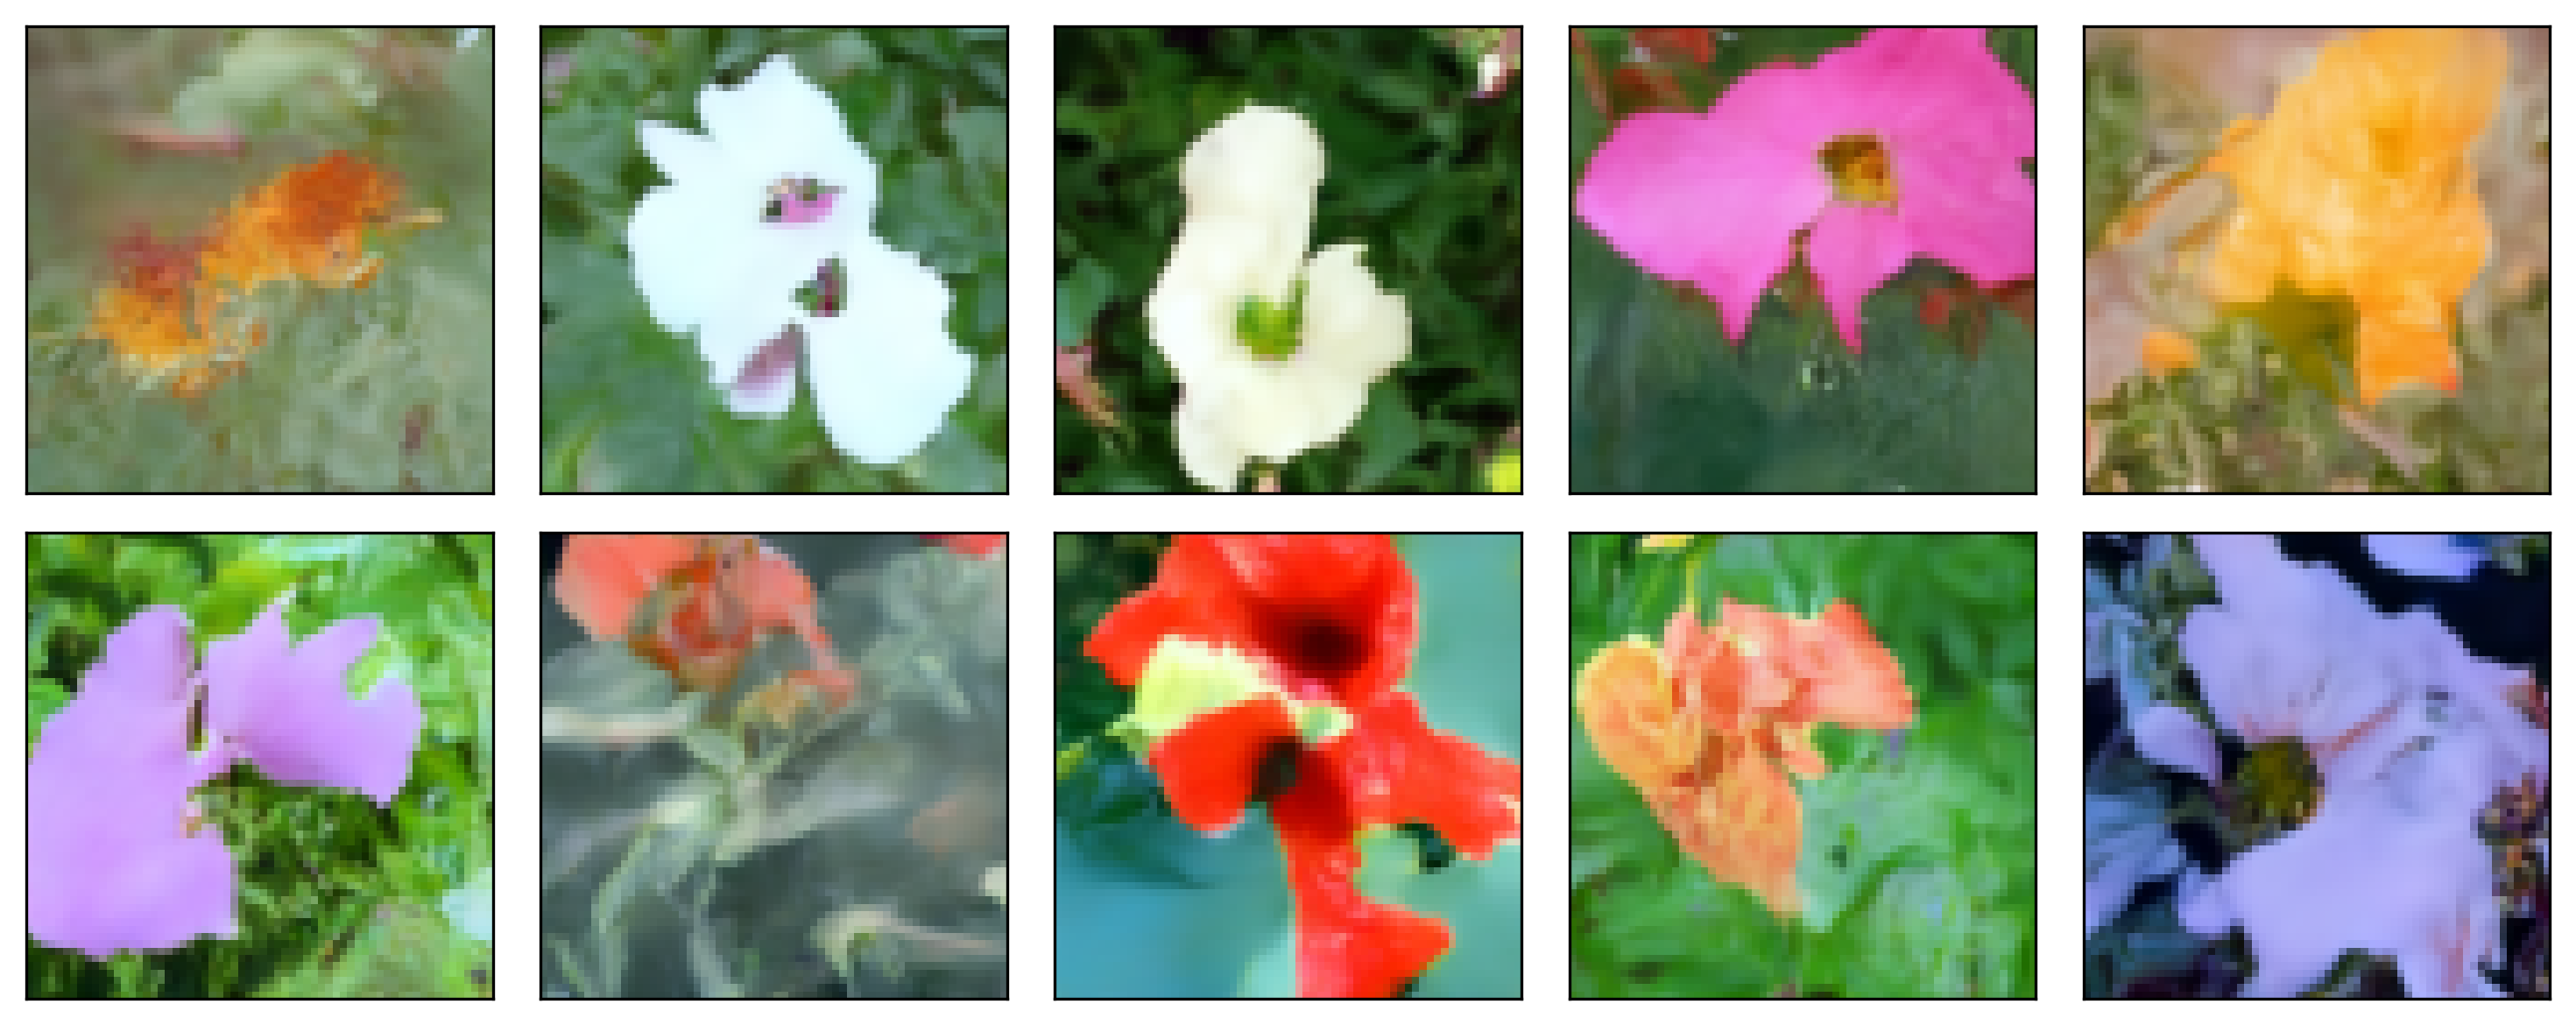

In [10]:
#sd=torch.load('files/diffusion.pth')
sd=torch.load(r'E:\ManningStuff\Rebecca\chapter14\files\diffusion.pth')

model.load_state_dict(sd)
with torch.no_grad():
    generator = torch.manual_seed(100)
    generated_images,imgs = noise_scheduler.generate(
        model,device=device,
        num_inference_steps=50,
        generator=generator,
        eta=0,
        use_clipped_model_output=True,
        batch_size=10)
imgnp=generated_images

import matplotlib.pyplot as plt
plt.figure(figsize=(10,4),dpi=300)
for i in range(10):
    ax = plt.subplot(2,5, i + 1)
    plt.imshow(imgnp[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()

## 5.2 Transition from One Image to Another
We have defined the following interpolate() method in the DDIMScheduler() class in ddim_util.py:

```python
@torch.no_grad()
def interpolate(self,model,a_idx,b_idx,batch_size=1,generator=None,
    eta=1.0,use_clipped_model_output=True,num_inference_steps=50,
             device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    image0 = torch.randn((batch_size, model.in_channels, 
      model.sample_size, model.sample_size),generator=generator,
                         ).to(device)
    image = torch.zeros((batch_size, model.in_channels, 
      model.sample_size, model.sample_size)).to(device)
    # pick two initial noise tensors
    a,b=image0[a_idx],image0[b_idx]
    # interpolate with different weights
    for i in range(10):
        ab=torch.sin(torch.tensor(0.5*math.pi*(0.05+i/10)))*a+\
            torch.cos(torch.tensor(0.5*math.pi*(0.05+i/10)))*b
        image[i]=ab
    self.set_timesteps(num_inference_steps)
    # generate 
    for t in tqdm(self.timesteps):
        model_output = model(image, t)["sample"]
        image = self.step(model_output,t,image,eta,
          use_clipped_model_output=use_clipped_model_output,
                          generator=generator)
    image = unnormalize_to_zero_to_one(image)
    image = image.cpu().permute(0, 2, 3, 1).numpy()
    return image
```

Let's create a series of images that gradually transition from the second image to the eighth image:

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.06s/it]


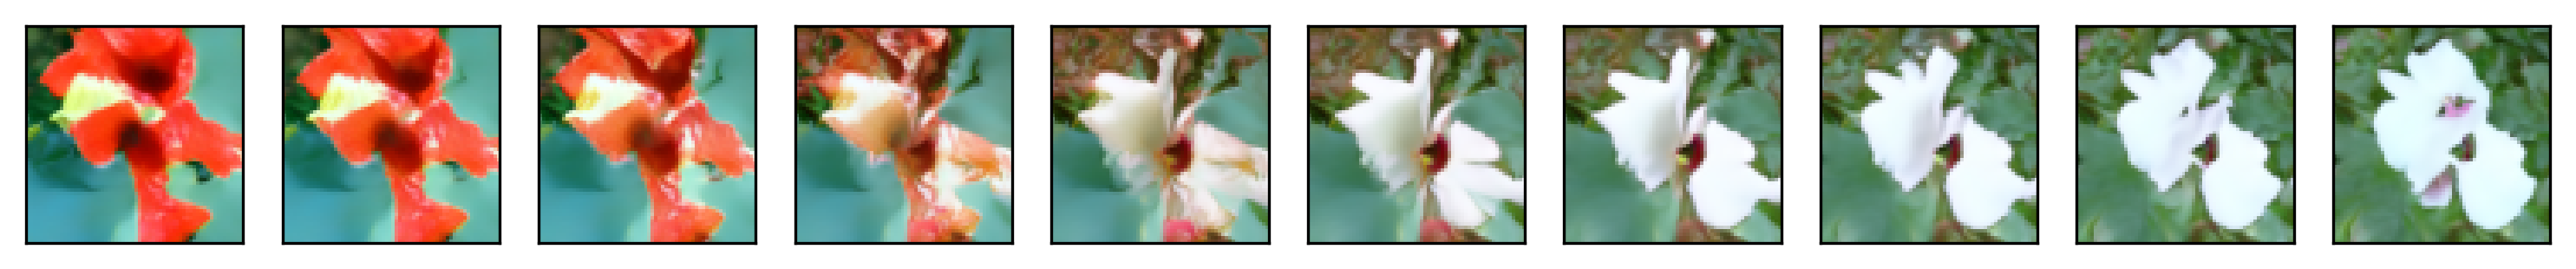

In [11]:
with torch.no_grad():
    generator = torch.manual_seed(100)
    generated_images = noise_scheduler.interpolate(
        model,1,7,
        num_inference_steps=50,
        generator=generator,
        eta=0,
        use_clipped_model_output=True,
        batch_size=10)
    
imgnp=generated_images 

import matplotlib.pyplot as plt
plt.figure(figsize=(10,4),dpi=300)
for i in range(10):
    ax = plt.subplot(1,10, i + 1)
    plt.imshow(imgnp[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()

Similarly, you can gradually transition from the third to the sixth and so on. 

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.06s/it]


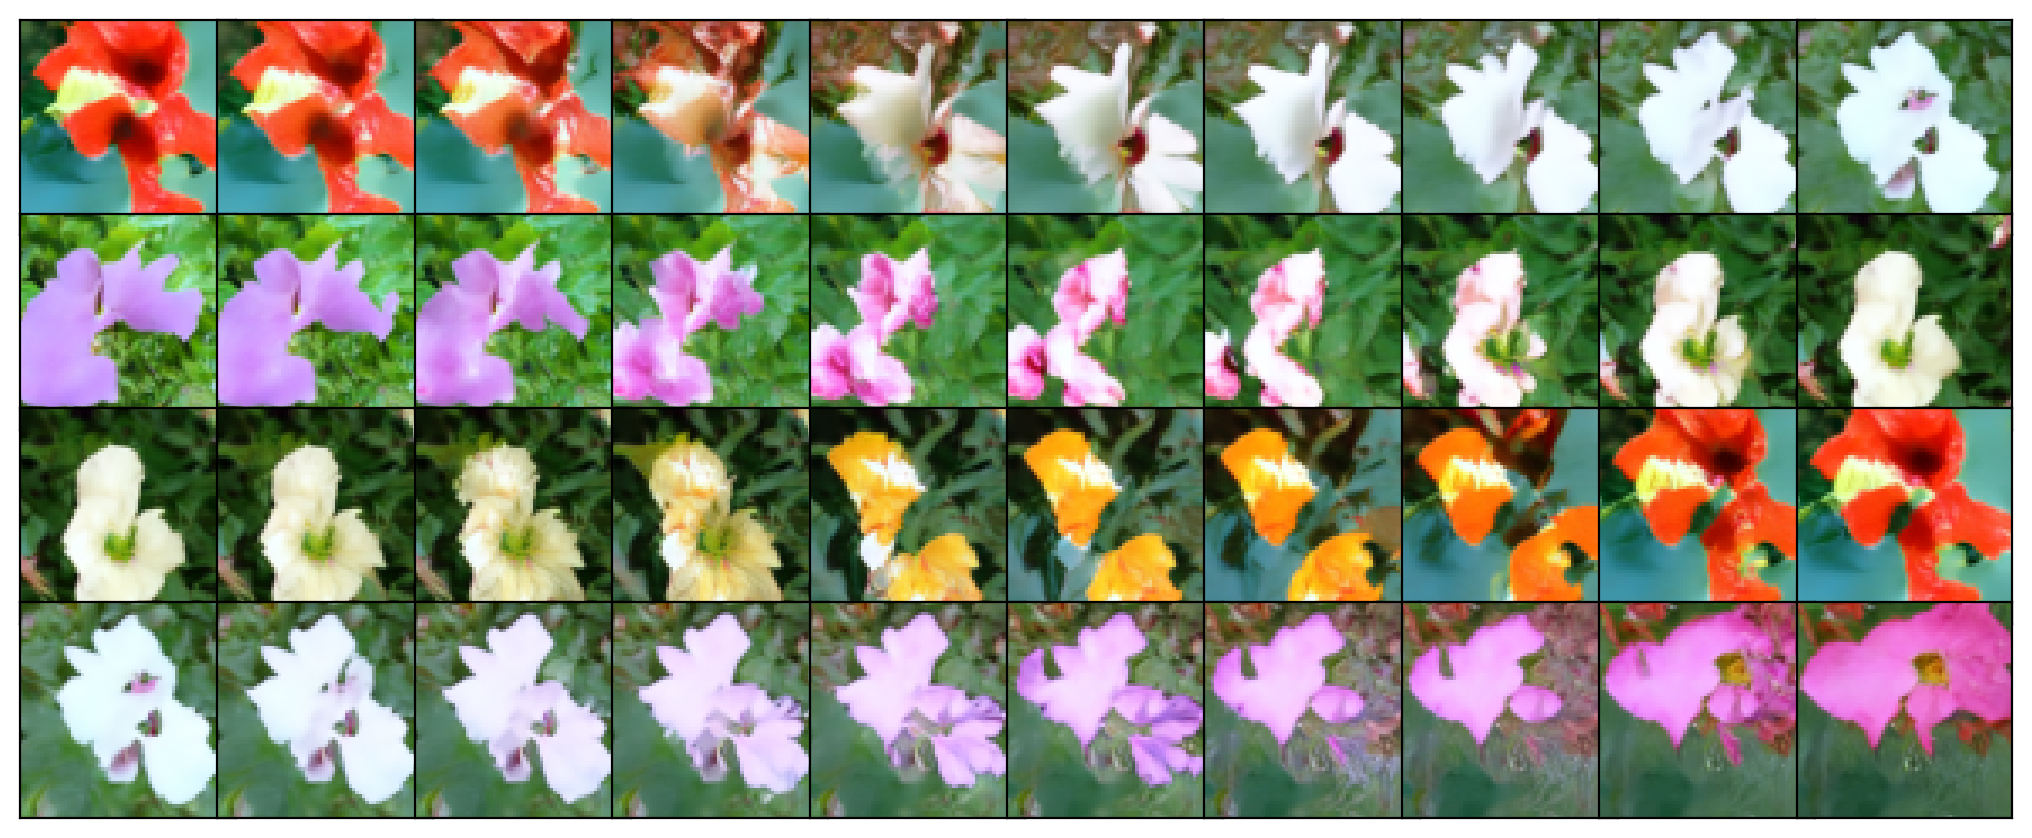

In [12]:
with torch.no_grad():
    generator = torch.manual_seed(100)
    generated_images = noise_scheduler.interpolate(
        model,2,5,
        num_inference_steps=50,
        generator=generator,
        eta=0,
        use_clipped_model_output=True,
        batch_size=10)
imgnp1=generated_images
with torch.no_grad():
    generator = torch.manual_seed(100)
    generated_images = noise_scheduler.interpolate(
        model,7,2,
        num_inference_steps=50,
        generator=generator,
        eta=0,
        use_clipped_model_output=True,
        batch_size=10)
imgnp2=generated_images
with torch.no_grad():
    generator = torch.manual_seed(100)
    generated_images = noise_scheduler.interpolate(
        model,3,1,
        num_inference_steps=50,
        generator=generator,
        eta=0,
        use_clipped_model_output=True,
        batch_size=10)
imgnp3=generated_images 

import numpy as np
img_array=np.concatenate([imgnp,imgnp1,imgnp2,imgnp3])
fig, axs = plt.subplots(nrows=4, 
            ncols=10,sharex=True,
            sharey=True,figsize=(10,4),dpi=200)
for row in range(4):
    for col in range(10):
        axs[row, col].clear()
        axs[row, col].set_xticks([])
        axs[row, col].set_yticks([])
        axs[row, col].imshow(img_array[col+row*10])
plt.subplots_adjust(bottom=0.001,right=0.999,top=0.999,
left=0.001, hspace=-0.1,wspace=-0.1)